In [ ]:
from BERTModel import Model
import os
import pymongo
from datetime import date


In [ ]:
def deriv(y, t, beta, gamma, sigma, N, zeta, k):
    # Set up the differential equations. For reference:
    # S = # of Susceptible, E = # of Exposed (non-infectious), I = Infectious, R = Resistant
    # Beta = Expected infection rate of one person in a day, Gamma = Probability of death when infected, Sigma = Incubation period of Virus, Zeta = Popular Sentiment, k = "Sentiment Factor" a.k.a a constant to represent the importance of sentiment, alpha = How much one's sentiment changes per change in infected population.
    # Mortality time was taken from Zhou et. al, "Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study"
    # Time between experiencing symptoms and infectivity was taken from "https://www.health.harvard.edu/diseases-and-conditions/if-youve-been-exposed-to-the-coronavirus"
    # Lastly, the model assumes that an individual cannot be reinfected by the virus, though it is still uncertain whether this is accurate, and it assumes that those experiencing symptoms will no longer interact with others as either they quarantine or are hospitalized.
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N + k / zeta(t)
    dEdt = beta(t) * S * I / N + k / zeta(t) - sigma * E
    dIdt = sigma * E - 1/3 * (1 - gamma) * I
    dRdt = 1/3 * (1 - gamma) * I  - 1/8.5 * gamma * R
    dDdt = 1/8.5 * gamma * R
    #dZetadt = zeta(t) * I * alpha # Experimental implementation, may not be used.
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lmfit
import scipy

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

model = Model()

client = pymongo.MongoClient('172.16.18.46:27017')
client.test.authenticate('test', 'passw0rd')
TweetCollection = client.tweets.tweets

In [ ]:
# totals = []
# for day in TweetCollection.distinct("date"):
#     tweets = []
#     for tweet in TweetCollection.find({"date": day}):
#         tweets.append(tweet["text"])
#     predictions = model.getPrediction(tweets)
#     total = 0
#     for prediction in predictions:
#         total = prediction[2]/4 + total
#     totals.append(total/len(tweets))

In [ ]:
def zeta(t):
    return totals[int(t) - 5]

In [ ]:
aggdeaths = pd.DataFrame()

In [ ]:
for i in range(6, 31):
    if i < 10:
        day = "0" + str(i)
    else:
        day = str(i)
    temp = pd.read_csv("/workspace/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/06-" + day + "-2020.csv")
    deaths = temp["Deaths"].sum()
    aggdeaths = aggdeaths.append(pd.Series(["06-" + day + "-2020", deaths]), ignore_index = True)

In [40]:
sigma = 1/5 # According to Lauer, et al.

#R0 represents the number of people that one infected individual can go on to infect.
def logistic_R_0(t, R_0_start, l, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-l*(-t+x0))) + R_0_end

def Model(days, R_0_start, l, x0, R_0_end, gamma, k):
    def beta(t):
        return logistic_R_0(t, R_0_start, l, x0, R_0_end) * gamma
    N = 331027545
    y0 = N - 1821073, 79723, 61722, 1575411, 104217
    t = np.linspace(0, days - 1, days)
    ret = scipy.integrate.odeint(deriv, y0, t, args=(beta, gamma, sigma, N, zeta, k))
    S, E, I, R, D = ret.T

    return t, S, E, I, R, D, gamma, k

In [ ]:
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0),
                       "x0": (15, 0, 39), 
                       "R_0_end": (0.9, 0.3, 3.5),
                       "gamma": (.032, 0.005, .1),
                       "k": (100, 0.01, 1000),
                       "l": (2.5, 0.01, 5.0)}

In [ ]:
x_data = np.linspace(0, 25 - 1, 25, dtype=int)

In [ ]:
death_data = pd.read_csv("covid_deaths_usafacts.csv")
death_data = death_data.iloc[:, 4:]

In [ ]:
sums = death_data.sum(axis=0)[-28:-3]

In [ ]:
y_data = np.array(sums)

In [ ]:
def fitter(x, R_0_start, l, x0, R_0_end, gamma, k):
    ret = Model(25, R_0_start, l, x0, R_0_end, gamma, k)
    deaths_predicted = ret[5]
    return deaths_predicted[x]

In [ ]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [ ]:
result = mod.fit(y_data, params, method=fit_method, x=x_data)

In [ ]:
params

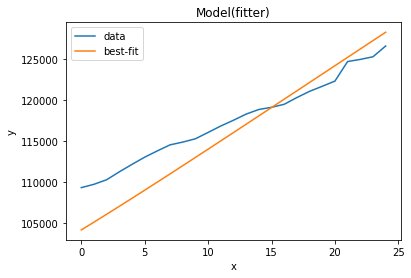

In [19]:
result.plot_fit(datafmt="-")

In [20]:
result.best_values


{'R_0_start': 4.40403022002404,
 'l': 2.450021174065444,
 'x0': 38.985978046959765,
 'R_0_end': 2.041367137041323,
 'gamma': 0.005082548662331884,
 'k': 53.64013192670941}

In [ ]:
y_data

In [ ]:
plt.plot(y_data)

In [ ]:
np.linspace(0, 24, 25)

In [42]:
ret = Model(31, 4.40403022002404, 2.450021174065444, 38.985978046959765, 2.041367137041323, 0.005082548662331884, 53.64013192670941)

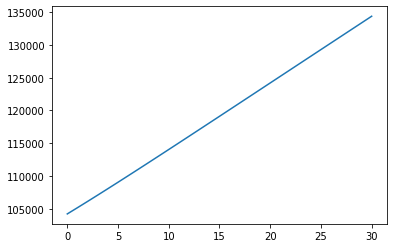

In [49]:
plt.plot(ret[5])

In [47]:
ret[4]

array([1575411.        , 1594119.29228277, 1611023.03778714,
       1626020.21876314, 1639143.8055102 , 1650500.13002375,
       1660235.38846316, 1668513.45068449, 1675500.53644592,
       1681356.35352539, 1686227.99045297, 1690249.24795003,
       1693539.11052329, 1696203.25012654, 1698333.62686225,
       1700008.94358097, 1701296.97885278, 1702255.99473476,
       1702937.12891721, 1703383.86215489, 1703632.20461355,
       1703713.37820295, 1703654.98408155, 1703479.64588457,
       1703205.54993838, 1702849.63527913, 1702425.06647564,
       1701944.6404558 , 1701416.50899488, 1700846.66519441,
       1700239.98452141])